# Управление рисками 2024. Домашнее задание №1.

*Дата выдачи: 06.03.2024*

*Дедлайн: 20.03.2024, 23:59*

## Часть 1. График линейности признака по WoE.

В этой части домашки мы познакомимся с одним из основных инструментов для анализа переменных в модели логистической регрессии - графиком линейности. 

Кратко идею этого графика можно сформулировать так:
 - модель *линейной* регрессии корректно применять, если значение $y$ *линейно* связано со значением $x$. Иначе линрег не подходит для данной задачи и даст неверные результаты.
 - аналогичную проверку хочется сделать и для *логистической* регрессии. Но как проверить линейность, если таргет принимает всего два значения?
 - для этого необходимо преобразовать таргет: разбить признак на бакеты и в каждом бакете посчитать WoE
 - **линейность признака по WoE для логрега – аналог линейной связи признака и таргета для линрега**

Ниже пример признака с неплохой линейностью:

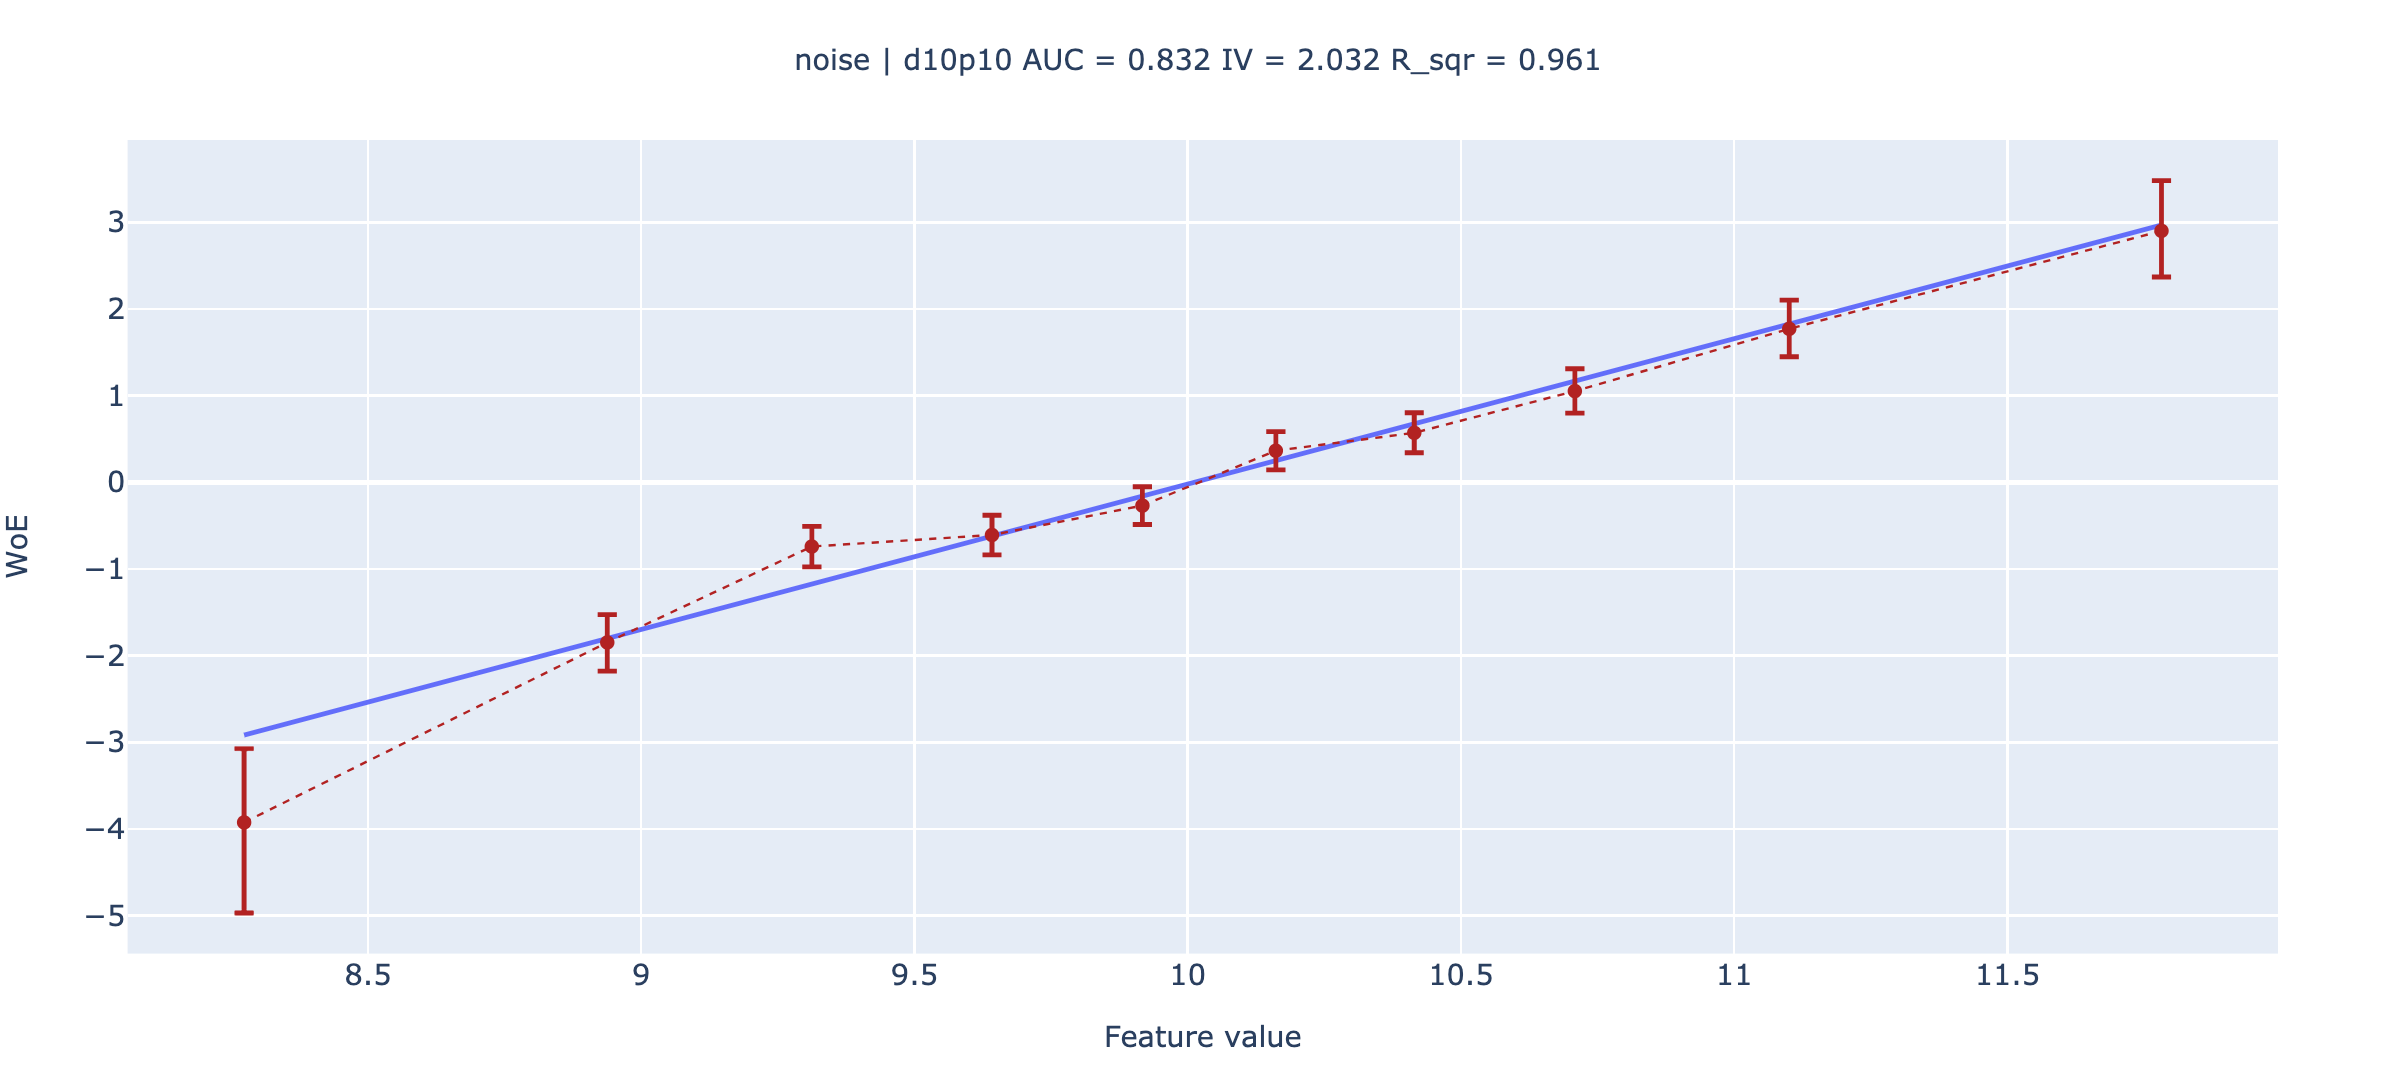

Нам нужно обратить внимание на 3 вещи:

**1. Фиолетовые точки с доверительными интервалами.**

Это WoE для каждого отдельного бакета. В идеале нам бы хотелось, чтобы **через эти точки можно было провести прямую линию** с небольшой погрешностью. Это и означает линейную взаимосвязь с таргетом.

**2. Синяя линия**

Попытка провести прямую линию через точки. Строится с помощью логистической регрессии на одной переменной. Затем предсказания переводятся в пространство WoE, отчего и получается прямая линия.

**3. Метрики в заголовке графика**

Метрики для признака:
 - roc auc, IV измеряют разделяющую способность переменной
 - $R^2$ измеряет *линейность взаимосвязи*. Признак считается линейным, если $R^2 \geq 0.95$

Далее напишем woe-line руками, чтобы в деталях разобраться, как он строится.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
from typing import Union, Tuple

### Шаг 0: разбиение на бакеты

In [3]:
def calc_buckets(x : Union[np.ndarray, pd.Series], n_buckets : int) -> np.ndarray:
    """Разбивает массив значений признака x на 
    n_buckets бакетов"""

    x = pd.Series(x).reset_index(drop=True)
    buckets = x.rank(method="dense", pct=True) * n_buckets
    buckets = np.ceil(buckets) - 1   # np.floor дает другой результат для 5.0, 6.0 и т.д.
    buckets = np.array(buckets, dtype=np.int16)

    return buckets

In [4]:
# протестируйте calc_buckets
print((calc_buckets(np.array([1,1,10,3,4,5,2, 2, 100, 1000, 10000]), 3)))
print(calc_buckets(np.array([1,2,3, 4, 10, 100, 101,1000, 10000]), 3))

[0 0 1 0 1 1 0 0 2 2 2]
[0 0 0 1 1 1 2 2 2]


### Шаг 1: расчет WoE по бакетам

Пусть $x_i \in \{ 0, 1\}^n$

$x_i$ - это вектор, состоящий из значений таргета *в одном бакете* $i$. 

Для бакета можно посчитать количество единиц $B_i$ (bads, выпавшие в дефолт) и количество нулей $G_i$ (goods).

$$
B_i = \sum_{j \in x_i} \mathbb{I} \{ j = 1\}\quad G_i = \sum_{j \in x_i} \mathbb{I} \{ j = 0\}
$$

Также число бэдов и гудов можно посчитать и **для всей выборки**: 

$$
% X = x_1 \cup x_2 \ldots \cup x_n
X = \{x_1,\; x_2\; \ldots\; x_n\}
$$

$$
B = \sum_{j \in X} \mathbb{I} \{ j = 1\}\quad G = \sum_{j \in X} \mathbb{I} \{ j = 0\}
$$

Тогда WoE можно посчитать как

$$
\text{WoE}_i(x) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) 
$$

**Задание**

Убедиться, что

$$
\text{WoE}_i(x) = \text{logit}(b_i) - \text{logit}(b)\quad  (1)
$$

где 

$$
b = \frac{B}{B + G}\quad \text{logit}(p) = \ln \Big (  \frac{p}{1 - p} \Big )
$$

В дальнейшем будем считать WoE по формуле $(1)$

In [5]:
from scipy.special import logit

def woe_transform(badrate : float, offset : float) -> float:
    """Считаем WoE для бакета с данным badrate и выборки
    с данным offset."""
    woe = logit(badrate) - offset
    return woe

Здесь и далее предлагается протестироать получившиеся функции. Нужно проверить, что
 - функция не ложится с ошибкой
 - возвращает то, что ожидается

In [6]:
# протестируй woe_transform
print(woe_transform(1, 1))

print(woe_transform(1, 0.5))

print(woe_transform(0.5, 1))

print(woe_transform(0, 1))

print(woe_transform(10, 3))

inf
inf
-1.0
-inf
nan


Ниже представлен шаблон функции, которая будет считать доверительный интервал к нашим вычислениям. Можно воспользоваться любым способом, который вам больше нравится. Для идей можно посмотреть различные способы подсчета доверительного интервала [здесь](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).

**P. S.**
Для того, чтобы построить доверительный интервал к $WoE$, можно сначала построить его для величины  $b_i = \frac{B_i}{B_i+G_i}$, а потом применить ```woe_transform```. В свою очередь величина $b_i$ является параметром распределения Бернулли, который мы можем оценить классическими методами (см. ссылку выше)

In [7]:
from scipy.stats import norm    


def woe_ci(target : np.ndarray, buckets : np.ndarray, offset : float) -> Tuple[pd.Series]:
    """Для каждого бакета вычисляем WoE и доверительный
    интервал для него."""
    # считаем бэдрейт и доверительный интервал для него (любым способом)
    bucket_sizes = np.bincount(buckets)
    badrate = np.bincount(buckets, weights=target) / bucket_sizes
    
    badrate[badrate == 1] = 1 - 1e-3
    badrate[badrate == 0] = 1e-3
    z_quantile = norm.ppf(0.975)
    
    badrate_lower = badrate - z_quantile * np.sqrt((badrate * (1 - badrate)) / bucket_sizes)
    badrate_upper = badrate + z_quantile * np.sqrt((badrate * (1 - badrate)) / bucket_sizes)
    
    badrate_lower[badrate_lower <= 0] = 1e-3
    badrate_upper[badrate_upper >= 1] = 1 - 1e-3
    
    # переходим от бэдрейта к woe    
    woe = woe_transform(badrate, offset)
    woe_lower = woe_transform(badrate_lower, offset)
    woe_upper = woe_transform(badrate_upper, offset)
    

    return woe, woe_lower, woe_upper

values = np.array([1,1,10,3,4,5,2, 2])
target = np.array([0, 1, 1, 0, 1, 1, 0, 0])
buckets = calc_buckets(values, 3)
offset = logit(sum(target) / len(target))

woe_ci(target, buckets, offset)

(array([-1.09861229,  0.        ,  6.90675478]),
 array([-6.90675478, -6.90675478,  3.05961426]),
 array([0.72790172, 6.90675478, 6.90675478]))

### Шаг 2: расчет линейной интерполяции

In [8]:
from sklearn.linear_model import LogisticRegression

def calc_line(values : np.ndarray, target : np.ndarray, mean_feature : np.ndarray, offset : float) -> np.ndarray:
    """Строим линейную интерполяцию для WoE."""

    # строим логистическую регрессию на одном признаке
    # и считаем ее предсказания в точках – mean_feature
    model = LogisticRegression()
    model.fit(values.reshape(-1, 1), target)
    proba = model.predict_proba(mean_feature.reshape(-1, 1))[:, 1]
    line = woe_transform(proba, offset)
    
    return line

In [9]:
# протестируйте calc_line

values = np.array([1,1,10,3,4,5,2, 2])
target = np.array([0, 1, 1, 0, 1, 1, 0, 0])
buckets = calc_buckets(values, 3)
offset = logit(sum(target) / len(target))


backets_len = np.bincount(buckets)
mean_feature = np.bincount(buckets, weights=values) / backets_len

calc_line(values, target, mean_feature, offset)

array([-0.92997075,  0.24016673,  2.58044169])

### Шаг3: собираем результаты по бакетам в один словарь

In [10]:
def calc_buckets_info(values : np.ndarray, target : np.ndarray, buckets : np.ndarray) -> dict:
    """Для каждого бакета расчитывает
     - среднее значение признака
     - линейную интерполяцию в пространстве woe
     - значение woe и доверительный интервал для него"""

    buckets_len = np.bincount(buckets)
    mean_feature = np.bincount(buckets, weights=values) / buckets_len
    
    offset = logit(sum(target) / len(target))
    woe, woe_lower, woe_upper = woe_ci(target, buckets, offset)
    buckets_info = {
        "mean_feature" : mean_feature,
        "line"         : calc_line(values, target, mean_feature, offset),
        "woe"          : woe,
        "woe_lower"    : woe_lower,
        "woe_upper"    : woe_upper
    }

    return buckets_info

In [11]:
# протестируйте calc_buckets_info

values = np.array([1,1,10,3,4,5,2, 2])
target = np.array([0, 1, 1, 0, 1, 1, 0, 0])
buckets = calc_buckets(values, 3)
offset = logit(sum(target) / len(target))

backets_len = np.bincount(buckets)
mean_feature = np.bincount(buckets, weights=values) / backets_len
print("buckets: ", buckets)

weights = np.bincount(buckets)
print("weights: ", weights)

print("buckets_info:")
calc_buckets_info(values, target, buckets)

buckets:  [0 0 2 1 1 2 0 0]
weights:  [4 2 2]
buckets_info:


{'mean_feature': array([1.5, 3.5, 7.5]),
 'line': array([-0.92997075,  0.24016673,  2.58044169]),
 'woe': array([-1.09861229,  0.        ,  6.90675478]),
 'woe_lower': array([-6.90675478, -6.90675478,  3.05961426]),
 'woe_upper': array([0.72790172, 6.90675478, 6.90675478])}

### Шаг 4: считаем метрики признака

Рассчитаем также несколько метрик, чтобы судить о качестве признака не только по картинкам. 

Приведем формулу для IV:

$$
\text{IV}(x) = \sum_{i = 1}^{n}\Big ( \frac{B_i}{B} - \frac{G_i}{G} \Big ) \times \text{WoE}_i
$$

**Вопрос:** зачем считать ранжирующую силу признака двумя способами? Какую дополнительную информацию может дать IV относительно roc auc?

**Ответ:** Auc для признака показывает только то, какую долю пар объектов мы верно упорядочили используя данный призак, он не показывает насколько в целом распределения различны, в отличие от iv. Auc отлавливает только монотонное разделение выборки по признаку (большему значению фичи больший таргет либо наоборот). Собственно iv напротив смотрит на то сколь сильно отличаются распредления и позволяет находить любые, а не только монотонные зависимости.

In [12]:
from sklearn.metrics import roc_auc_score, r2_score

def calc_plot_title(
        values : np.ndarray,
        target : np.ndarray,
        buckets : np.ndarray
    ) -> str:
    
    buckets_info = calc_buckets_info(values, target, buckets)
    backets_woe = buckets_info["woe"]
    """Считает для признака roc auc, IV, R^2"""
    
    auc = roc_auc_score(target, values)

    # формула выше
    total_bad = sum(target)
    total_good = len(target) - total_bad
    
    backets_bad = np.bincount(buckets, weights=target) 
    backets_good = np.bincount(buckets, weights=~target) 
    IV = sum((backets_bad / total_bad - backets_good / total_good) * backets_woe)

    # Взвешенный R^2 
    # X - среднее в бакете, Y - woe в бакете, вес – число наблюдений в бакете
    backets_len = np.bincount(buckets)

    R_sqr = r2_score(backets_woe, buckets_info["line"], sample_weight=backets_len)
    # R_sqr = r2_score(buckets_info["mean_feature"], backets_woe, sample_weight=backets_len)

    plot_title = (        
        f"AUC = {auc:.3f} "
        f"IV = {IV:.3f} "
        f"R_sqr = {R_sqr:.3f} "
    )

    return plot_title

In [13]:
# протестируйте calc_plot_title
calc_plot_title(values, target, buckets)

'AUC = 0.781 IV = 8.712 R_sqr = 0.578 '

### Шаг 5: собираем все в одну функцию и строим график

In [14]:
# в этот код можно не въезжать :)
import plotly.graph_objects as go

def make_figure(buckets_info : dict, plot_title : str) -> go.Figure:
    """Строит график линейности."""
    fig = go.Figure()

    # общие настройки
    title = dict(
        text=plot_title,
        y=0.95,
        x=0.5,
        font=dict(size=12),
        xanchor="center",
        yanchor="top"
    )
    margin = go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=60
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["line"],
            mode='lines',
            name="interpolation_line",
            showlegend=False
        )
    )

    fig.add_trace(
        go.Scatter(
            x=buckets_info["mean_feature"],
            y=buckets_info["woe"],
            line=dict(
                color='firebrick',
                width=1,
                dash='dot'
            ),
            error_y=dict(
                type='data',
                symmetric=False,
                array=buckets_info["woe_upper"],
                arrayminus=buckets_info["woe_lower"]
            ),
            name="WoE",
            showlegend=False)
    )

    fig.update_layout(
        width=1000,
        height=450,
        xaxis_title=dict(
            text='Feature value',
            font=dict(size=12)
        ),
        yaxis_title=dict(
            text="WoE",
            font=dict(size=12)
        ),
        title=title,
        margin=margin
    )

    return fig

In [15]:
def woe_line(
        values : np.ndarray,
        target : np.ndarray,
        n_buckets : int
    ) -> go.Figure:
    """График линейности переменной по WoE."""
    buckets : np.ndarray = calc_buckets(values, n_buckets)
    buckets_info : pd.DataFrame = calc_buckets_info(values, target, buckets)
    plot_title : str = calc_plot_title(values, target, buckets)
    fig = make_figure(buckets_info, plot_title)
    return fig

Чтобы протестировать реализацию, сгенерируем синтетические данные:

In [16]:
sample_size = int(1e4)
noise_std = 1.

df = pd.DataFrame()
y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
df['target']  = y

np.random.seed(89)
x = np.concatenate([sps.norm(0, noise_std).rvs(size = sample_size // 2), sps.norm(1, noise_std).rvs(size = sample_size // 2)])
df['feature'] = x
df

,target,feature
0,0,-1.693730
1,0,-0.002121
2,0,-0.425892
3,0,-0.255590
4,0,-0.305779
...,...,...
9995,1,1.502826
9996,1,0.785328
9997,1,1.772374
9998,1,1.194998


<Axes: xlabel='feature', ylabel='Count'>

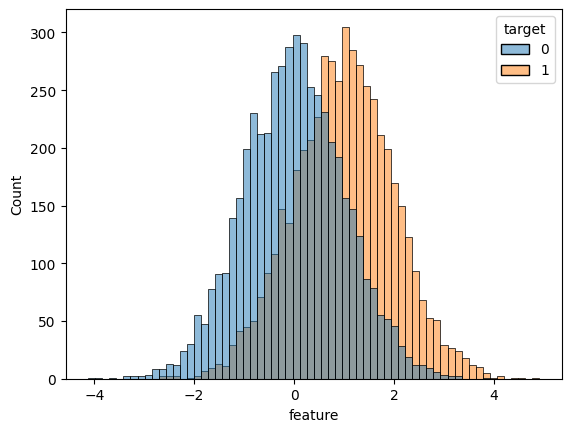

In [17]:
sns.histplot(df, x = 'feature', hue = 'target')

In [18]:
# запустите после того, как реализуете все функции 
woe_line(values=x, target=y, n_buckets=5)

### Эксперименты

#### №1

Как будут меняться график, метрики разделяющей способности и $R^2$ при изменении дисперсии шума (параметр `noise_std`)?

Понятно что и $R^2$ и IV монотонно(практически) убывают, однако видно, что разделюящая сила признака падает значительно быстрее (сразу практически до 0), $R^2$ оказывается менее чувствительным к большой дисперсии шума. В принципе все логично, при большом шуме если посмотреть на гистограммы видно, что распределения становятся очень широкмими и сильно налегающими друг на друга(практически одинаковыми), на линейность шум влияет существенно меньше

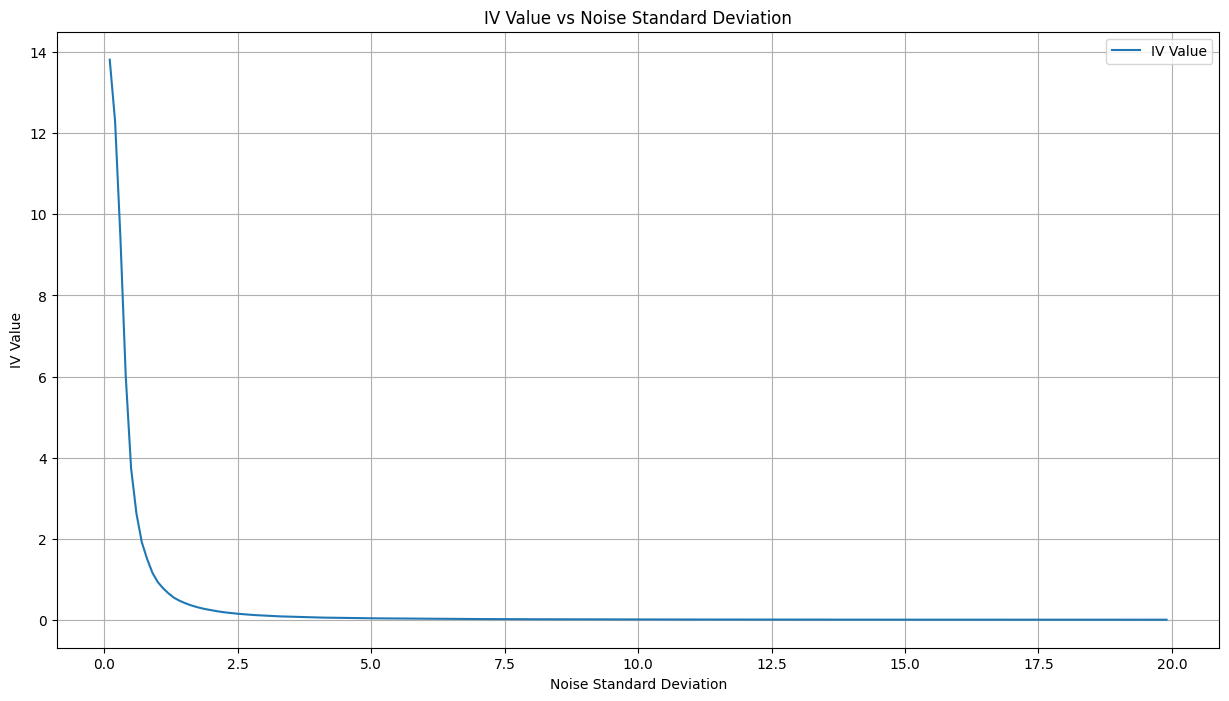

In [27]:
import re
from typing import List, Tuple
import seaborn as sns
import matplotlib.pyplot as plt

def gen_data(sample_size: int, noise_std: float, seed: int = 89) -> pd.DataFrame:
    df = pd.DataFrame()
    y = np.array(sample_size // 2 * [0] + sample_size // 2 * [1])
    df["target"] = y

    np.random.seed(seed)
    x = np.concatenate(
        [
            sps.norm(0, noise_std).rvs(size=sample_size // 2),
            sps.norm(1, noise_std).rvs(size=sample_size // 2),
        ]
    )
    df["feature"] = x
    return df


n_samples = 10**4
noise_std = np.arange(0.1, 20, 0.1)
n_buckets = 10

def get_iv_r2(noise_std: List[float], n_buckets: int) -> Tuple[List[float], List[float]]:
    pattern = r"IV = (\d+\.\d+) R_sqr = (-?\d+\.\d+)"
    iv_values, r2_values = [], []

    for noise in noise_std:
        df = gen_data(sample_size, noise)
        buckets = calc_buckets(df["feature"].values, n_buckets)
        title = calc_plot_title(df["feature"].values, df["target"].values, buckets)
        matches = re.search(pattern, title)

        iv_values.append(float(matches.group(1)))
        r2_values.append(float(matches.group(2)))

    return iv_values, r2_values


iv_values, r2_values = get_iv_r2(noise_std, 10)
sorted_noise_std = sorted(noise_std)
iv_values_sorted = [iv for _, iv in sorted(zip(noise_std, iv_values))]
r2_values_sorted = [r2 for _, r2 in sorted(zip(noise_std, r2_values))]

plt.figure(figsize=(15, 8))
plt.gca().set_yticks(range(0, 30, 2))  
sns.lineplot(x=sorted_noise_std, y=iv_values_sorted, label='IV Value')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('IV Value')
plt.title('IV Value vs Noise Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()


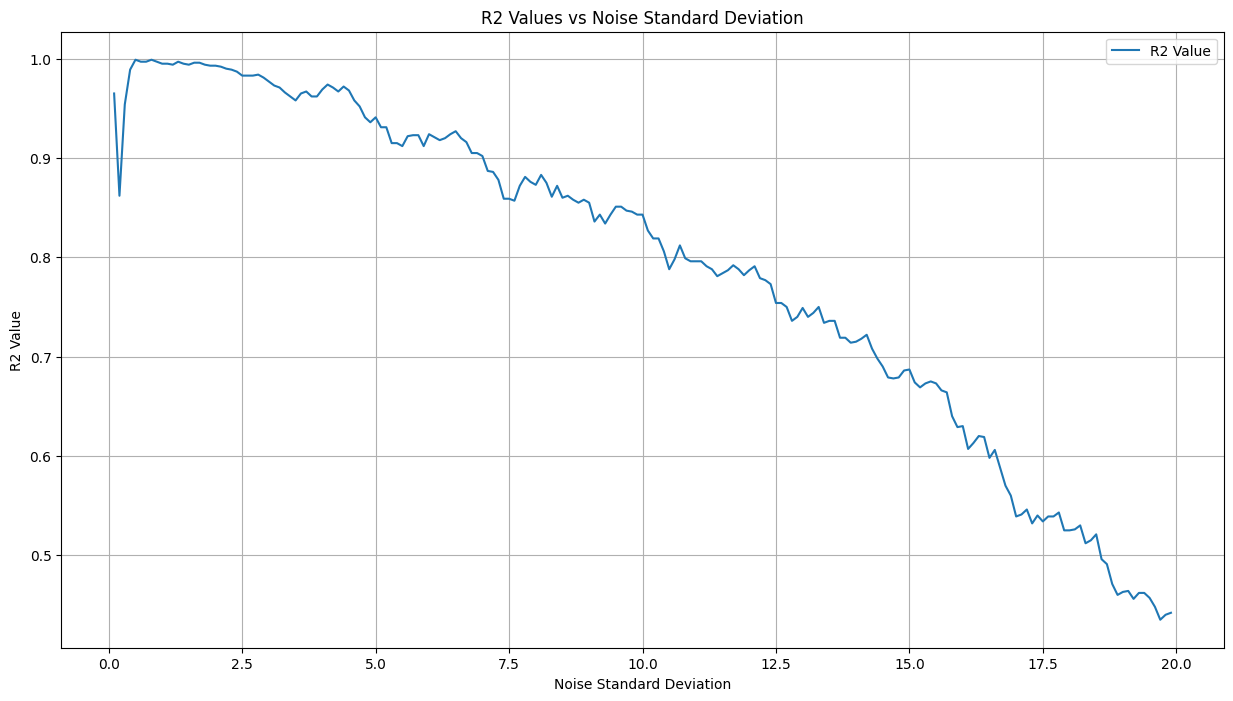

In [26]:
plt.figure(figsize=(15, 8))
plt.gca().set_yticks(np.arange(0, 1.1, 0.1))
sns.lineplot(x=sorted_noise_std, y=r2_values, label='R2 Value')
plt.xlabel('Noise Standard Deviation')
plt.ylabel('R2 Value')
plt.title('R2 Values vs Noise Standard Deviation')
plt.grid(True)
plt.legend()
plt.show()

#### №2

Запустите функцию с `values=x ** 2`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

График похож на график корня, не в точности поскольку он также зависит от плотности распределения из которой извлечены x, поскольку в нашем случаи x из нормального расрпделения, бакеты для значений близких к 0 короче. В таком случае самое лучшее что можно сделать, это сделать то преобразование которое напоминает график. В нашем случае корень

In [28]:
woe_line(values=x**2, target=y, n_buckets=10)

#### №3

Запустите функцию с `values=np.exp(x)`. Как по графику определить эту ситуацию? Что нужно делать в таком случае?

То же самое, график напоминает логарифм, значит надо взять логарифм

In [24]:
woe_line(values=np.exp(x), target=y, n_buckets=10)

## Часть 2. Строим ЛогРег.

В этом пунтке попробуем применить все наши навыки 

Скачайте датасет по [ссылке](https://data.tinkoff.ru/s/Nca7PoTNYokXgNF). Пароль вы найдете в телеграм-канале курса, в посте с анонсом домашки.

In [29]:
df = pd.read_csv('risks-24-hw1.csv', index_col=0)
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.417794,0.182394,-0.582374,0,-9.959913,-0.582374,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.009963,0.308079,6.889658,0,-4.517188,6.889658,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


Как вы выдите, ```feature_1, ..., feature_14``` - числа 
```feature_15``` - категориальная фича

### Задание 0. EDA.

Как бы вы начали знакомиться с данными до построения модели? Постройте 3-5 графиков / таблиц, чтобы передать основную информацию о датасете.

In [30]:
df.isnull().sum()

feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
d4p12         0
dtype: int64

In [31]:
df.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,d4p12
count,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,100000.000000
mean,-0.004065,-0.198827,-6.283870,-1.250730e-01,1.003480,2.973727,0.901520,-2.514795,2.973727,3.640370,-256.924907,1.013153,9.969348e+02,2.885691e-01,0.425370
std,2.625003,169.576125,2344.152317,5.939374e-01,1.004035,3.998071,0.297964,5.009291,3.998071,4.977886,260.742462,2.314468,4.699415e+03,3.785086e-01,0.494401
min,-54.598150,-38296.171946,-10000.000000,-1.999994e+00,0.000002,-16.569150,0.000000,-26.496544,-16.569150,-16.847030,-1012.820365,-9.210340,1.666947e-19,6.195140e-11,0.000000
25%,-1.011666,-0.385200,-4.215224,-2.289926e-01,0.288478,0.281313,1.000000,-5.893561,0.281313,0.270052,-506.548930,-1.262413,3.451754e+00,1.371482e-03,0.000000
50%,-0.058406,-0.072894,0.003200,-2.253828e-09,0.694669,2.971161,1.000000,-2.511154,2.971161,3.669848,-282.922772,-0.800022,2.341854e+01,4.439380e-02,0.000000
75%,1.004057,0.395806,4.255211,1.127132e-01,1.389851,5.663969,1.000000,0.859395,5.663969,6.984301,-0.080408,3.344923,1.536384e+02,6.085319e-01,1.000000
max,39.011329,20133.753873,10000.000000,9.999952e-01,12.006909,19.874766,1.000000,19.258719,19.874766,24.764462,446.685530,3.951220,3.729609e+05,1.000000e+00,1.000000


In [32]:
df.dtypes

feature_1     float64
feature_2     float64
feature_3     float64
feature_4     float64
feature_5     float64
feature_6     float64
feature_7       int64
feature_8     float64
feature_9     float64
feature_10    float64
feature_11    float64
feature_12    float64
feature_13    float64
feature_14    float64
feature_15     object
d4p12           int64
dtype: object

Обычно я начинаю eda с графика частот для каждого признака, данный график позволяет оценить распределение каждого признака, можно сразу обнаружить выбросы или дефолтные значения
Найти сильно смещенные распределения, понять какие признаки нельзя моделировать гаусовским распределением (данное рассуждение имеет смысл в случае если мы хотим применить дискриминантый анализ, либо найти выбросы с помощью boxplot)
  
Здесь мы сразу обнаруживаем наличие огромных значений в признаках 2 3 15, которые в дальнейшем можем выборсить


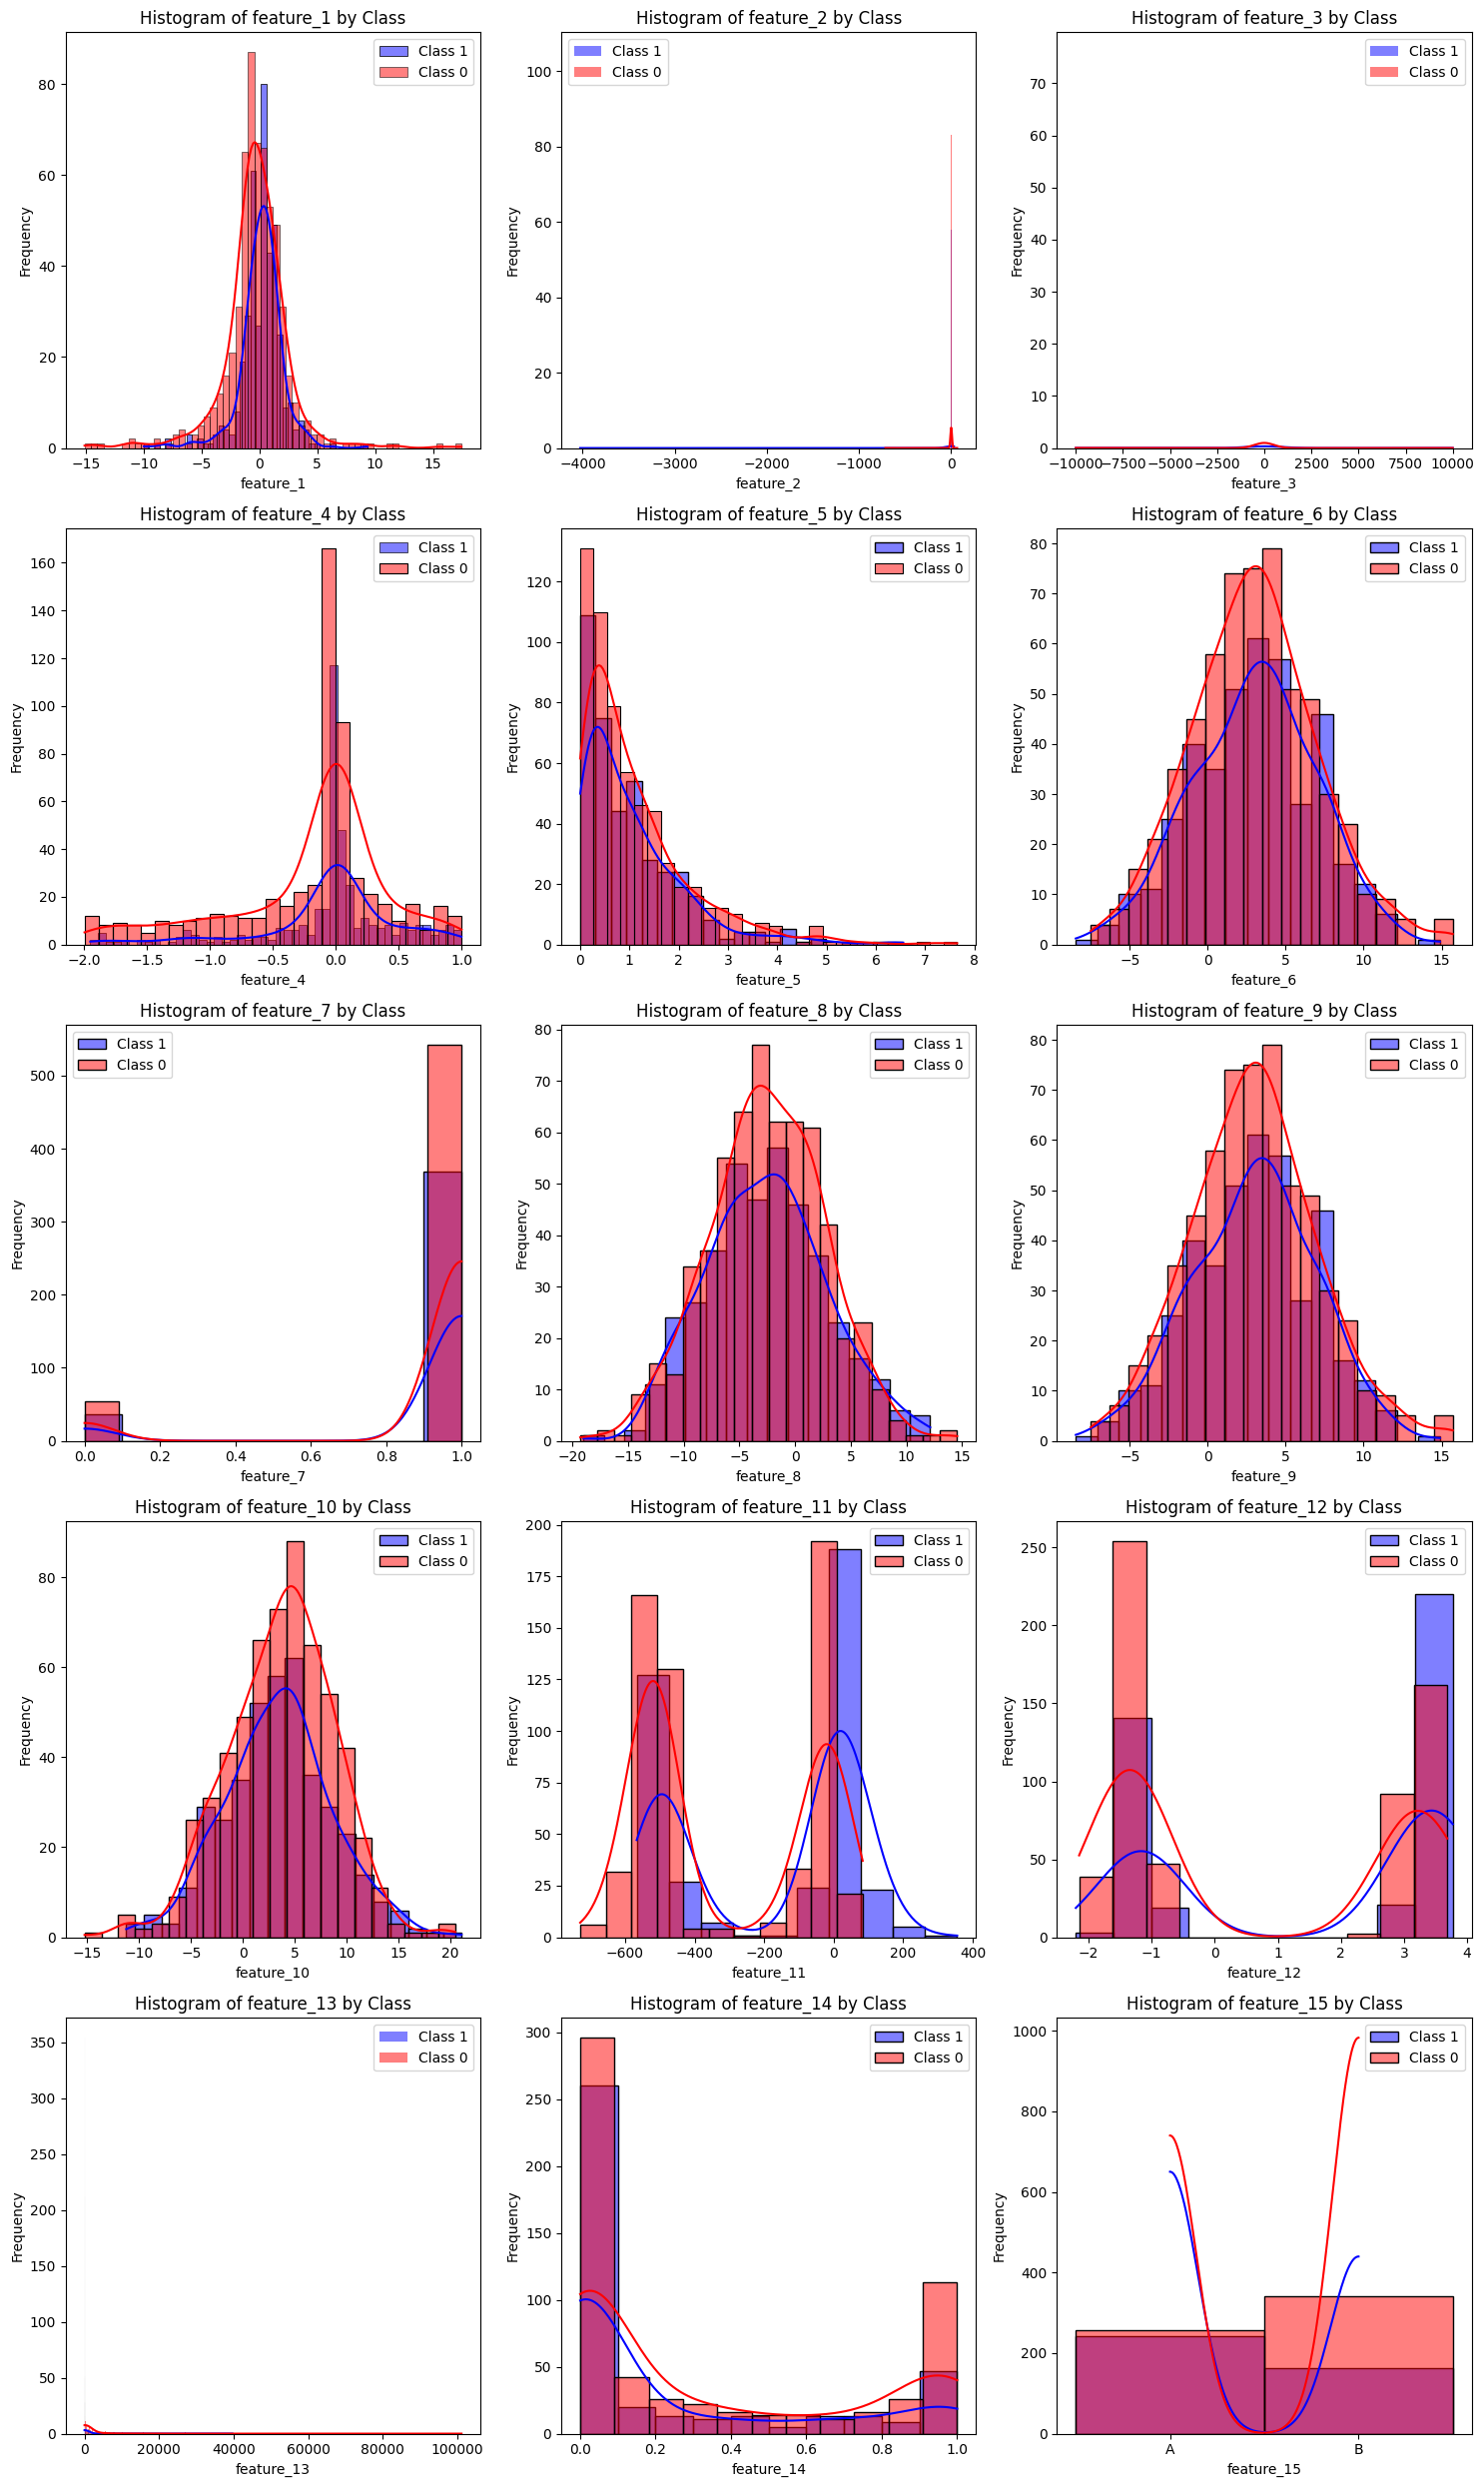

In [27]:
import seaborn as sns


num_features = len(df.columns[:-1]) 
num_cols = 3  
num_rows = int(np.ceil(num_features / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))


sub_df = df.sample(1000)
for i, feature in enumerate(df.columns[:-1]):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    sns.histplot(sub_df[sub_df[sub_df.columns[-1]] == 1][feature], kde=True, color='blue', label='Class 1', ax=ax)
    sns.histplot(sub_df[sub_df[sub_df.columns[-1]] == 0][feature], kde=True, color='red', label='Class 0', ax=ax)
    
    ax.set_title('Histogram of {} by Class'.format(feature))
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()


plt.tight_layout()
plt.show()

In [33]:
df[["feature_2", "feature_3", "feature_13"]].describe()

,feature_2,feature_3,feature_13
count,100000.000000,100000.000000,1.000000e+05
mean,-0.198827,-6.283870,9.969348e+02
std,169.576125,2344.152317,4.699415e+03
min,-38296.171946,-10000.000000,1.666947e-19
25%,-0.385200,-4.215224,3.451754e+00
50%,-0.072894,0.003200,2.341854e+01
75%,0.395806,4.255211,1.536384e+02
max,20133.753873,10000.000000,3.729609e+05


Для выбранных на прошлом шаге признаков с помощью violentplot можно оценить количество и мастштаб выбросов

<Axes: >

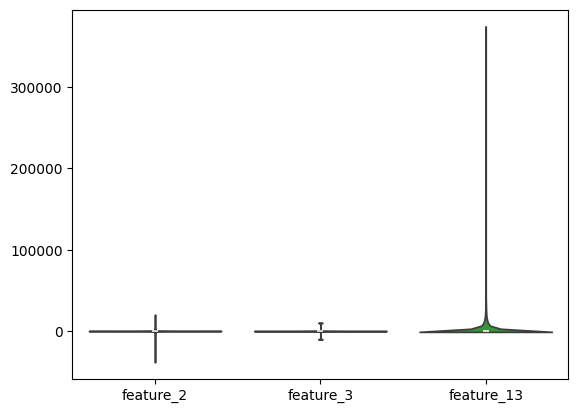

In [30]:
sns.violinplot(df[["feature_2", "feature_3", "feature_13"]])

Построим матрицу корреляции чтобы обнаружить признаки с сильной линейной зависимостью  
В данном случаи обнаруживаем полную линейную зависимость между признаками 6 и 9, а также 11 и 12  
Поскольку мы строим линейню модель нам точно нужно выкинуть линейно зависимые признаки, чтобы уменьшить дисперсию оценок коэфициентов логрега

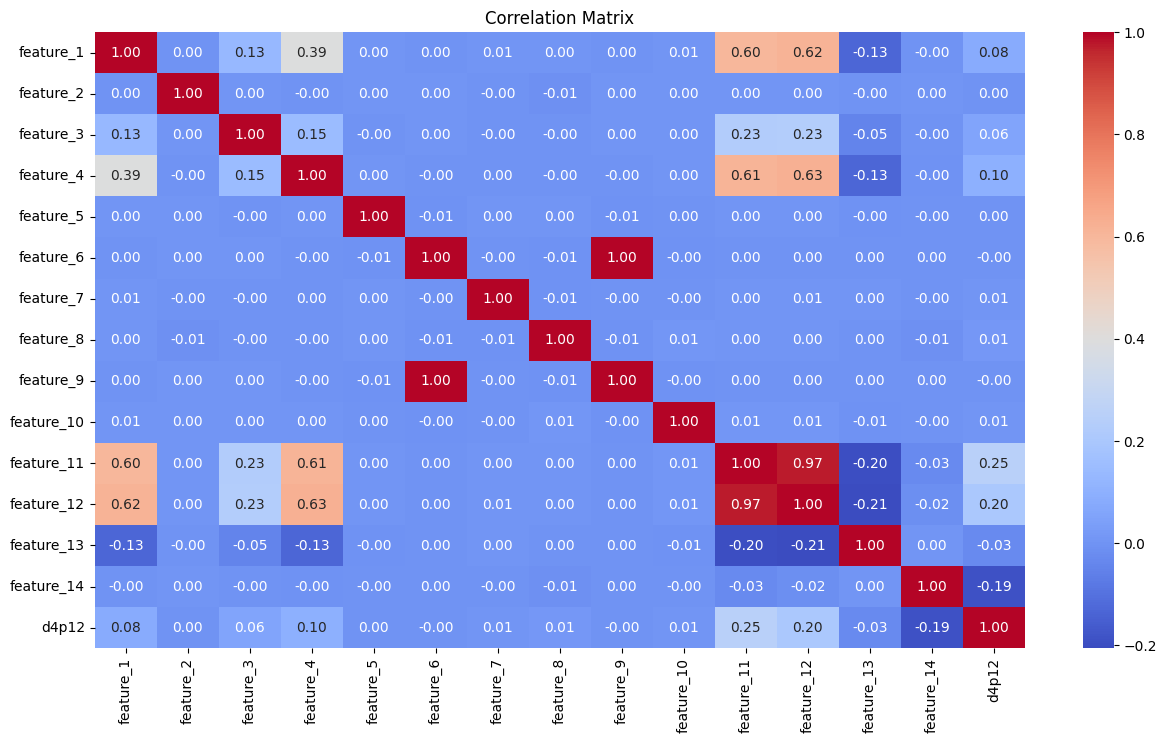

In [31]:
correlation_matrix = df[df.columns[df.columns != "feature_15"]].corr()

plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Задание 1. Бейзлайн.

Попробуйте построить ЛогРег только на числовых данных. Для этого разбейте датасет на трейн и тест (80/20). Перед обучением логрега стандартизуйте переменные. Это может быть полезно для численной устойчивости алгоритмов оптимизации.

Для этой модели и всех дальнейших:

1. Получилась ли модель линейной? Постройте график линейности на трейне и на тесте и сделайте вывод.
2. Расчитайте AUC и IV на трейне и на тесте. Что можно сказать о переобучении?

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
features, targets = df[df.columns[:-2]].to_numpy(), df["d4p12"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=0)
X_test.shape

(20000, 14)

In [36]:
pipline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

pipline.fit(X_train, y_train)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

### Woe line roc_auc и iv на train выборке

In [35]:
prediction = pipline.predict_proba(X_train)[:, 1]
woe_line(logit(prediction), y_train, 50)

### Woe line roc_auc и iv на test

In [36]:
prediction = pipline.predict_proba(X_test)[:, 1]
woe_line(logit(prediction), y_test, 50)

### Выводы:
* $R^2$ на train выборке превосходит 0.95 и ее можно считать линейной по woe, $R^2$ на test выборке немного меньше 0.95
* Модель не переобучилась, качество модели на train и test выборке практически одинаково (auc и iv практически не отличаются)

### Задание 2. Добавляем категориальную переменную.

Повторите задание 1, включив в модель категориальную переменную (например, с помощью one-hot encoding).

Улучшилось ли качество?

In [37]:
df["feature_15"] = (df["feature_15"] == "A").astype('int')
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,0,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,1,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,1,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,0,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.417794,0.182394,-0.582374,0,-9.959913,-0.582374,5.294558,-524.265291,-1.648415,5.410059,0.855190,0,0
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,1,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,1,1
99998,-1.431421,-0.605388,2.466023,-0.009963,0.308079,6.889658,0,-4.517188,6.889658,10.812813,-507.593408,-1.398568,1904.246147,0.077164,0,1


In [38]:
features, targets = df[df.columns[:-1]].to_numpy(), df["d4p12"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, stratify=targets, random_state=0)
X_train.shape


(80000, 15)

In [39]:
pipline.fit(X_train, y_train)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

In [40]:
prediction = pipline.predict_proba(X_train)[:, 1]
woe_line(logit(prediction), y_train, 50)

In [41]:
prediction = pipline.predict_proba(X_test)[:, 1]
woe_line(logit(prediction), y_test, 50)

### Выводы:
* Модель на train и test выборках близка к линейной, однако $R^2$  несколько меньше 0.95
* Модель не переобучается. Качество на train и test выборках практически совпадает
* Качество модели при добавлении feature_15 существенно выросло (разделяющая сила модели и auc существенно выросли)

### Задание 3. Линеаризация переменных.

На самом деле, категориальные переменные можно учитывать в моделях совсем по-другому. С их помощью можно выделить в модели сегменты. Каждому сегменту соответствует своя модель (в нашем случае логрег). 

Примером такой сегментации может стать сегментация по наличию кредитной истории. В этом случае на разных сегментах будут не просто отдельные модели, но и даже разный изначальный набор признаков. Другое свидетельство удачной сегментации – разный характер зависимости признаков и целевой переменной. Это можно увидеть на графике линейности признака по WoE. Этим мы и займемся далее.

Используйте переменную 15 для сегментации модели. На каждом из двух сегментов линеаризуйте переменные. Для этого приложите:
 - график линейности переменной до преобразования
 - график после подобранного преобразования

Помимо этого:
 - попробуйте линеаризовать какие-нибудь 2 переменные *на всей выборке*. Получилось ли у вас что-то? Постройте график.
 - по графику линейности определите шумовые (либо слабоинформативные) переменные. В конце задания приложите их список.

In [43]:
df["feature_15"].value_counts()

feature_15
0    50106
1    49894
Name: count, dtype: int64

In [46]:
A_df = df[df["feature_15"] == 1]
B_df = df[df["feature_15"] == 0]
A_df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,1,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,1,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,1,0
7,1.557416,-0.350312,-7.726001,0.163782,1.223096,7.679542,1,0.641899,7.679542,-1.863355,-37.248306,3.372350,26.960081,0.993832,1,0
8,1.703837,6.820164,-6.738079,0.715147,0.357916,7.067470,1,-5.834091,7.067470,-7.027793,-2.424817,3.150060,5.481141,0.915089,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,0.787295,-0.865919,-10.075984,0.005438,0.088516,-1.647395,1,-3.827898,-1.647395,-2.577229,44.195793,3.102307,62.690514,0.930469,1,0
99994,0.720604,-0.282323,-3.377249,0.000453,0.985110,6.490484,1,-3.962758,6.490484,10.985765,0.309638,3.325720,1.387933,0.006839,1,1
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,1,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,1,1


# Линеаризация для A

## feature_1

In [62]:
woe_line(A_df["feature_1"].values, A_df["d4p12"].values, 50)

In [63]:
woe_line(np.log(A_df["feature_1"].values), A_df["d4p12"].values, 50)

## feature_2

In [64]:
woe_line(A_df["feature_2"].values, A_df["d4p12"].values, 50)

In [65]:
woe_line(A_df["feature_2"].values**(-1), A_df["d4p12"].values, 50)

## feature_3

In [66]:
woe_line(A_df["feature_3"].values, A_df["d4p12"].values, 50)

In [67]:
woe_line(np.clip(A_df["feature_3"].values, -30, 10), A_df["d4p12"].values, 50)

## feature 4

In [68]:
woe_line(A_df["feature_4"].values, A_df["d4p12"].values, 50)

## feature 5

In [69]:
woe_line(A_df["feature_5"].values, A_df["d4p12"].values, 50)


## feature_6

In [70]:
woe_line(A_df["feature_6"].values, A_df["d4p12"].values, 50)

## feature 7

In [71]:
woe_line(A_df["feature_7"].values, A_df["d4p12"].values, 2)

## feture_8

In [72]:
woe_line(A_df["feature_8"].values, A_df["d4p12"].values, 50)

## feature_9

In [73]:
woe_line(A_df["feature_9"].values, A_df["d4p12"].values, 50)

## feature 10

In [74]:
woe_line(A_df["feature_10"].values, A_df["d4p12"].values, 50)

## feature_11

In [75]:
woe_line(A_df["feature_11"].values, A_df["d4p12"].values, 50)

In [47]:
def sign_square(values, pow):
    return np.sign(values) * np.abs(values)**pow

woe_line(sign_square(A_df["feature_11"].values, 1/3), A_df["d4p12"].values, 50)

## feature_12

In [77]:
woe_line(A_df["feature_12"].values, A_df["d4p12"].values, 50)

## feature_13

In [78]:
woe_line(A_df["feature_13"].values, A_df["d4p12"].values, 50)

## feature 14

In [79]:
woe_line(A_df["feature_14"].values, A_df["d4p12"].values, 50)

In [80]:
woe_line(logit(A_df["feature_14"].values), A_df["d4p12"].values, 50)

# Линеаризация для B

## feature_1

In [81]:
woe_line(B_df["feature_1"].values, B_df["d4p12"].values, 50)

In [ ]:
woe_line(np.log(-B_df["feature_1"].values), B_df["d4p12"].values, 30)

## feature_2

In [82]:
woe_line(B_df["feature_2"].values, B_df["d4p12"].values, 50)

In [83]:
woe_line(B_df["feature_2"].values ** (-1), B_df["d4p12"].values, 50)

## feature_3

In [84]:
woe_line(B_df["feature_3"].values, B_df["d4p12"].values, 50)

In [85]:
woe_line(np.clip(B_df["feature_3"].values, -5, 30), B_df["d4p12"].values, 50)

## feature_4

In [86]:
woe_line(B_df["feature_4"].values, B_df["d4p12"].values, 50)

## feature_5

In [87]:
woe_line(B_df["feature_5"].values, B_df["d4p12"].values, 50)

## feature 6

In [88]:
woe_line(B_df["feature_6"].values, B_df["d4p12"].values, 50)

## feature 7

In [89]:
woe_line(B_df["feature_7"].values, B_df["d4p12"].values, 2)

## feture_8

In [90]:
woe_line(B_df["feature_8"].values, B_df["d4p12"].values, 50)

## feature_9

In [91]:
woe_line(B_df["feature_9"].values, B_df["d4p12"].values, 50)

## feature_10

In [92]:
woe_line(B_df["feature_10"].values, B_df["d4p12"].values, 50)

## feature_11

In [93]:
woe_line(B_df["feature_11"].values, B_df["d4p12"].values, 50)

In [48]:
B_df["feature_11"].describe().quantile
print("0.03 quantile: ", B_df["feature_11"].quantile(0.03))
print("0.97 quantile: ", B_df["feature_11"].quantile(0.97))
print("mean feature_11: ", B_df["feature_11"].mean())

0.03 quantile:  -638.1564077769551
0.97 quantile:  -390.1228011957804
mean feature_11:  -509.92589615204173


In [57]:
woe_line(sign_square(np.clip(B_df["feature_11"].values, -700, 10000) + 510, 1/3), B_df["d4p12"].values, 50)

# feature_12

In [96]:
woe_line(B_df["feature_12"].values, B_df["d4p12"].values, 50)

# feature_13

In [98]:
woe_line(B_df["feature_13"].values, B_df["d4p12"].values, 50)

# feature 14

In [99]:
woe_line(B_df["feature_14"].values, B_df["d4p12"].values, 50)

In [100]:
woe_line(logit(B_df["feature_14"].values), B_df["d4p12"].values, 50)

### Список бесполезных неинформативных фичей
* feature_4
* feature_5
* feature_6
* feature_8
* feature_9
* feature_10
* feature_13

Также из за полной линейной зависимости я хотел выкинуть 11 или 12 признак (тот у кого iv меньше) из выборки чтобы уменьшить дисперсию оценок коэфициентов логрега,  
однако при выкидывании любого из признаков roc_auc падает аж до 0.86, видимо из за появления смещения в оценке. В задании сказано что должно получиться 0.9 поэтому пришлось оставить линейно зависимые признаки. Также у логрега по умолчанию стоит l2 регуляризация и здесь мы его сильно ограничиваем в итерациях (выдается предупреждение что lbfgs не закончил), возможно поэтому коэфициенты моделей не успевают разростаться так сильно

### Линеаризация для feature_2, feature_3 на всей выборке

#### feature_2

In [38]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,d4p12
0,-1.444709,3.554779,1.308371,-0.689329,0.366748,2.646755,1,8.825418,2.646755,11.565953,-513.014565,-1.072893,7.936545,0.047069,B,1
1,1.132531,-0.207661,-2.142882,0.000527,2.369319,8.712916,1,3.453220,8.712916,4.935665,-39.351891,3.409855,17.015210,0.029288,A,0
2,1.268781,-0.243999,10000.000000,0.000683,0.100580,2.137392,1,-10.116061,2.137392,6.234414,-4.993050,3.121126,4.878602,0.237255,A,0
3,-1.278475,-2.579890,5.050763,-0.371907,0.523984,2.612065,1,6.780814,2.612065,2.682539,-509.273095,-1.242741,20.293025,0.907788,B,0
4,3.507807,0.152661,-8.905005,0.939313,1.092974,4.224315,1,-10.638134,4.224315,6.881602,-2.034797,2.814972,7.352399,0.276854,A,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-3.061422,-0.163832,4.812768,-0.417794,0.182394,-0.582374,0,-9.959913,-0.582374,5.294558,-524.265291,-1.648415,5.410059,0.855190,B,0
99996,0.222451,-0.273191,0.380895,0.002889,3.724334,1.007479,1,-1.645952,1.007479,5.571499,-13.499956,3.386865,92.903615,0.006668,A,1
99997,1.078498,0.339526,-5.184847,0.234131,0.544720,-3.320917,1,-5.565932,-3.320917,-0.433263,3.928387,3.290285,1.233853,0.160933,A,1
99998,-1.431421,-0.605388,2.466023,-0.009963,0.308079,6.889658,0,-4.517188,6.889658,10.812813,-507.593408,-1.398568,1904.246147,0.077164,B,1


In [39]:
woe_line(df["feature_2"].values, df["d4p12"].values, 50)

In [40]:
woe_line(df["feature_2"].values ** (-1), df["d4p12"].values, 50)

#### feture_3

In [43]:
woe_line(df["feature_3"].values, df["d4p12"].values, 50)

In [49]:
woe_line(np.clip(df["feature_3"].values, -5, 10), df["d4p12"].values, 50)

### Выводы:
1) У меня не вышло линеаризовать данные признаки по всему датафрейму. Я честно говоря думал, что раз преобразование одно и тоже то все получится, однако ничего удивительного так то нет. Если посмотреть на прямые для feture_2 и feture_3 видно что зависимости разные. Для feature_2 A с ростом признака падает woe, а для feature_2 B с ростом признака растет woe. Для feture_3 A с ростом признака растет woe, для feature_3 B с ростом признака падает woe. Поскольку зависимости разные, когда мы пытаемся построить общую прямую ничего не получается

### Задание 4. Финальная модель.

Обучите модели на признаках, которые вы отобрали и линеаризовали в задании 3. Пусть $logit_A$ – модель, обученная на сегменте $feature_{15} = A$. $logit_B$ – модель на втором сегменте. Тогда модель на всей выборке будем считать по формуле

$$
logit(x) = \mathbb I \{ feature_{15} = A \} \times logit_A(x) + \mathbb I \{ feature_{15} = B \} \times logit_B(x)
$$


Посчитайте для этой модели AUC и IV, оцените линейность на трейне и тесте. Сравните результаты с бейзлайном из задания 1.

Подсказка: если вы все сделали правильно, можно ожидать ROC AUC около 0.9 на тестовой выборке.

In [142]:
informative_features = ["feature_1", "feature_2", "feature_3", "feature_7", "feature_11", "feature_12", "feature_14", "d4p12"]

A_df[informative_features]

,feature_1,feature_2,feature_3,feature_7,feature_11,feature_12,feature_14,d4p12
1,1.132531,-0.207661,-2.142882,1,-39.351891,3.409855,0.029288,0
2,1.268781,-0.243999,10000.000000,1,-4.993050,3.121126,0.237255,0
4,3.507807,0.152661,-8.905005,1,-2.034797,2.814972,0.276854,0
7,1.557416,-0.350312,-7.726001,1,-37.248306,3.372350,0.993832,0
8,1.703837,6.820164,-6.738079,1,-2.424817,3.150060,0.915089,0
...,...,...,...,...,...,...,...,...
99992,0.787295,-0.865919,-10.075984,1,44.195793,3.102307,0.930469,0
99994,0.720604,-0.282323,-3.377249,1,0.309638,3.325720,0.006839,1
99996,0.222451,-0.273191,0.380895,1,-13.499956,3.386865,0.006668,1
99997,1.078498,0.339526,-5.184847,1,3.928387,3.290285,0.160933,1


In [143]:
B_df[informative_features]

,feature_1,feature_2,feature_3,feature_7,feature_11,feature_12,feature_14,d4p12
0,-1.444709,3.554779,1.308371,1,-513.014565,-1.072893,0.047069,1
3,-1.278475,-2.579890,5.050763,1,-509.273095,-1.242741,0.907788,0
5,-0.773616,-0.320438,-1.658311,1,-494.737926,-1.381005,0.936676,0
6,-0.748825,0.260512,-3.468750,1,-494.944584,-1.205677,0.126881,1
11,-1.467083,-0.274845,0.435544,1,-589.471300,-1.361750,0.959790,0
...,...,...,...,...,...,...,...,...
99990,-3.930562,-0.717099,16.822749,1,-515.090305,-1.107287,0.285053,0
99991,-0.395737,0.290945,1.985617,1,-489.603207,-1.326132,0.913821,0
99993,-0.319742,1.052283,-0.616470,1,-518.806249,-1.287268,0.000007,1
99995,-3.061422,-0.163832,4.812768,0,-524.265291,-1.648415,0.855190,0


In [144]:
from copy import deepcopy
transformed_A_df = deepcopy(A_df[informative_features])

transformed_A_df["feature_1"] = np.log(transformed_A_df["feature_1"])
transformed_A_df["feature_2"] = transformed_A_df["feature_2"] ** (-1)
transformed_A_df["feature_3"] = np.clip(transformed_A_df["feature_3"], -30, 10)
transformed_A_df["feature_11"] = sign_square(transformed_A_df["feature_11"], 1/3)
transformed_A_df["feature_14"] = logit(transformed_A_df["feature_14"])


transformed_B_df = deepcopy(B_df[informative_features])
transformed_B_df["feature_1"] = np.log(-transformed_B_df["feature_1"])
transformed_B_df["feature_2"] = transformed_B_df["feature_2"] ** (-1)
transformed_B_df["feature_3"] = np.clip(transformed_B_df["feature_3"], -5, 30)
transformed_B_df["feature_11"] = sign_square(np.clip(transformed_B_df["feature_11"], -700, 390) + 510, 1/3)
transformed_B_df["feature_14"] = logit(transformed_B_df["feature_14"])

In [145]:
transformed_A_df

,feature_1,feature_2,feature_3,feature_7,feature_11,feature_12,feature_14,d4p12
1,0.124455,-4.815529,-2.142882,1,-3.401380,3.409855,-3.500855,0
2,0.238057,-4.098374,10.000000,1,-1.709183,3.121126,-1.167788,0
4,1.254991,6.550470,-8.905005,1,-1.267186,2.814972,-0.960119,0
7,0.443028,-2.854595,-7.726001,1,-3.339659,3.372350,5.082142,0
8,0.532883,0.146624,-6.738079,1,-1.343465,3.150060,2.377417,0
...,...,...,...,...,...,...,...,...
99992,-0.239153,-1.154843,-10.075984,1,3.535577,3.102307,2.593910,0
99994,-0.327666,-3.542045,-3.377249,1,0.676527,3.325720,-4.978242,1
99996,-1.503046,-3.660441,0.380895,1,-2.381099,3.386865,-5.003690,1
99997,0.075569,2.945285,-5.184847,1,1.577871,3.290285,-1.651305,1


In [146]:
transformed_features_A, transformed_target_A = transformed_A_df[transformed_A_df.columns[:-1]].to_numpy(), transformed_A_df["d4p12"].to_numpy()
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(transformed_features_A, transformed_target_A, test_size=0.2, stratify=transformed_target_A, random_state=0)
X_train_A.shape

(39915, 7)

In [147]:
final_pipline_A = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

final_pipline_A.fit(X_train_A, y_train_A)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

In [148]:
transformed_features_B, transformed_target_B = transformed_B_df[transformed_B_df.columns[:-1]].to_numpy(), transformed_B_df["d4p12"].to_numpy()
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(transformed_features_B, transformed_target_B, test_size=0.2, stratify=transformed_target_B, random_state=0)
X_train_B.shape

(40084, 7)

In [149]:
final_pipline_B = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", LogisticRegression())
])

final_pipline_B.fit(X_train_B, y_train_B)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

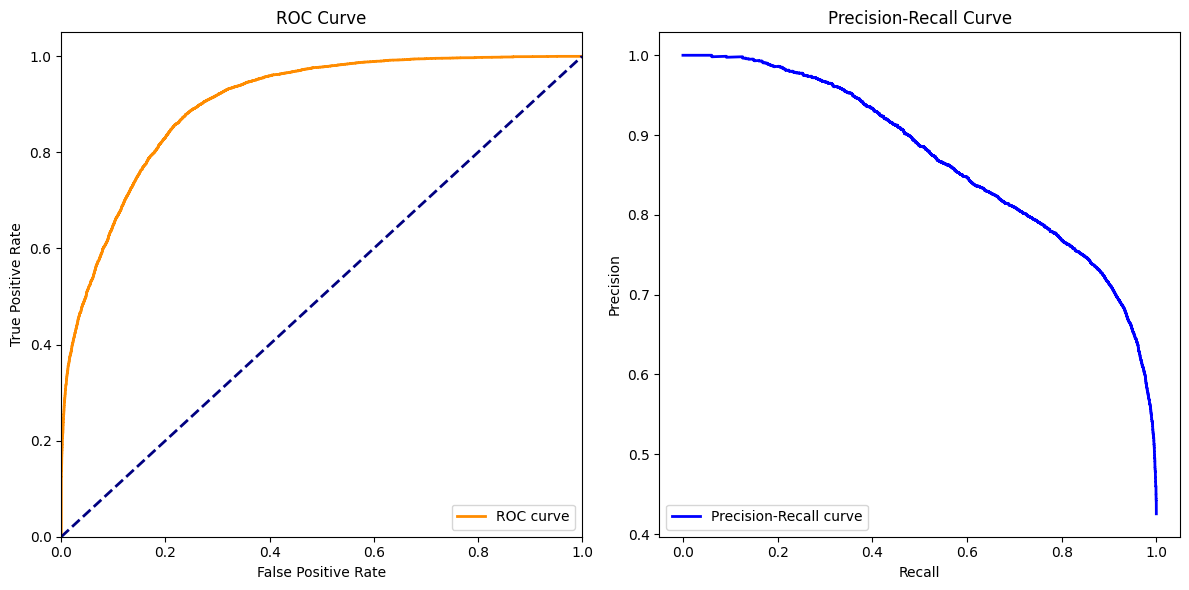

In [150]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt


prediction_A = final_pipline_A.predict_proba(X_test_A)[:, 1].reshape(-1, 1)
prediction_B = final_pipline_B.predict_proba(X_test_B)[:, 1].reshape(-1, 1)
final_predict = np.vstack([prediction_A, prediction_B])
true_labels = np.vstack([y_test_A.reshape(-1, 1), y_test_B.reshape(-1, 1)])

fpr, tpr, _ = roc_curve(true_labels, final_predict)
precision, recall, _ = precision_recall_curve(true_labels, final_predict)

plt.figure(figsize=(12, 6))

# ROC-кривая
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Precision-Recall кривая
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


### Результат итоговой модели на train выборке

In [151]:
prediction_train_A = final_pipline_A.predict_proba(X_train_A)[:, 1].reshape(-1, 1)
prediction_train_B = final_pipline_B.predict_proba(X_train_B)[:, 1].reshape(-1, 1)
final_train_predict = np.vstack([prediction_train_A, prediction_train_B])
true_train_labels = np.vstack([y_train_A.reshape(-1, 1), y_train_B.reshape(-1, 1)])

In [152]:
woe_line(logit(final_train_predict[:, 0]), true_train_labels[:, 0], 50)

### Результаты итоговой модели на test выборке

In [153]:
prediction_test_A = final_pipline_A.predict_proba(X_train_A)[:, 1].reshape(-1, 1)
prediction_test_B = final_pipline_B.predict_proba(X_train_B)[:, 1].reshape(-1, 1)
final_train_predict = np.vstack([prediction_train_A, prediction_train_B])
true_train_labels = np.vstack([y_train_A.reshape(-1, 1), y_train_B.reshape(-1, 1)])

In [154]:
woe_line(logit(final_predict[:, 0]), true_labels[:, 0], 50)

### Выводы:
* Новая модель показывает наилучший результат и очень существенно отличается по качеству от base модели
* Модель не склонна к переобучению (что логично учитывая то что здесь мы не подбирали гипперпараметры, да и в принципе это линейная модель)
* Коэфициент $R^2$ новой модели близок к 0.98 (на обоих выборках), что позволяет уверенно говорить о том что модель является линейной


сравнение результатов с baseline:
1) AUC:      $0.71 -> 0.90$
2) IV:       $0.53 -> 2.58$

# Часть 3. Бонус.

На лекции мы накопили ряд упражнений, которые стоит решить для понимания происходившего. Вы можете $\TeX$ать их прямо в ноуте (или прикреплять картинки, если так удобнее).

#### **Упражнение 1**

Для определения $WoE$ мы пользовались Теоремой Байеса. Примените ее и **покажите, что верно равенство**:

$$
\ln \left(  \frac{P(x_i|y=1)}{P(x_i|y=0)} \right) = ... = \ln \left( \frac{P(y=1|x_i)}{P(y=0|x_i)} \right) - \ln \left( \frac{P(y=1)}{P(y=0)} \right)
$$

$$
\ln\left(\frac{P(x_i | y=1)}{P(x_i| y = 0)}\right) = \ln\left(\frac{\left(\frac{p(y = 1 | x_i) \cdot p(x_i)}{p(y=1)}\right)}{\left(\frac{p(y=0 | x_i) \cdot p(x_i)}{p(y = 0)}\right)}\right) = \ln\left(\frac{p(y = 1 | x_i)}{p(y = 0 | x_i)}\right) - \ln\left(\frac{p(y = 1)}{p(y = 0)}\right)
$$

#### **Упражнение 2**

Известно:

$WoE$ можно посчитать так:
$WoE_i(x_i) = \ln \Big ( \frac{B_i}{G_i} \Big ) - \ln \Big ( \frac{B}{G} \Big ) $

Частота выхода в дефолт:  $badrate = \frac{B}{B+G}; \quad badrate_i = \frac{B_i}{B_i+G_i}$

$
\sigma (x) = \frac{1}{1+e^{-x}}; \quad logit(x) = \ln \left( \frac{x}{1-x} \right)
$

**Покажите, что**
$WoE_i(x_i) = logit(badrate_i) - logit(badrate)$

\begin{align*}
\text{logit(badrate)} &= \ln\left(\frac{B}{B+G} \middle/ \frac{G}{B+G}\right) \\
\text{logit(badrate}_i) - \text{logit(badrate)} &= \ln\left(\frac{B_i}{B_i + G_i} \middle/ \frac{G_i}{B_i + G_i}\right) - \ln\left(\frac{B}{B+G} \middle/ \frac{G}{B+G}\right) \\
&= \ln\left(\frac{B_i}{G_i}\right) - \ln\left(\frac{B}{G}\right) = \text{WoE}
\end{align*}


#### **Упражнение 3**

Пусть даны два дискретных распределения: 

$B=(b_1, ..., b_n)$ и $G=(g_1, ..., g_n)$.

KL-дивергенция для дискретных распределений

$$D_{KL}(B||G) = \sum_{j=1}^{n} b_j \ln \left( \frac{b_j}{g_j} \right)$$


Пусть $x$ - дикретный признак, принмиающий значения $x_1,...,x_n$.
Известно определение IV через KL-дивергенцию:

$$
IV_x = D_{KL}(B_x||G_x)+D_{KL}(G_x||B_x)
$$
где 

$$
B_x (x_i) = P(x=x_i|y=1) = b_i; \quad G_x (x_i) = P(x=x_i|y=0) = g_i
$$

**Выразите $IV$ через $WoE$**





\begin{align*}
IV &= \sum_{i}(b_i \cdot \ln(\frac{b_i}{g_i})) + \sum_{i}(g_i \cdot \ln(\frac{g_i}{b_i})) \\
&= \sum_{i}(b_i - g_i) \cdot \ln(\frac{b_i}{g_i}) \\
&= \sum_{i}(p(x_i|y=1) - p(x_i|y=0)) \cdot \ln\left(\frac{p(y=1|x_i)p(x_i)}{p(y=1)} \middle/ \frac{p(y=0|x_i)p(x_i)}{p(y=0)}\right) \\
&= \sum_{i}(p(x_i|y=1) - p(x_i|y=0)) \cdot \ln\left(\frac{p(y=1|x_i)}{p(y=0|x_i)}\right) - \ln\left(\frac{p(y=1)}{p(y=0)}\right) \\
&= \sum_{i}(b_i - g_i) \cdot \text{woe}
\end{align*}
